In [ ]:
# mount the google drive folder
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [ ]:
!pip install --quiet git+https://github.com/theislab/scgen.git

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

### Import the metric -- scib

In [3]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

# !pip install --quiet scib
import scib

In [4]:
# !pip install --quiet louvain
import louvain

## Import the data

In [5]:
import anndata
adata = anndata.read_h5ad("../Lung_two_species_raw.h5ad")
adata

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/orig.ident' was written without encoding metadata.
  return func(*args, **kwargs)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/orig.ident' was written without encoding metadata.
  return func(*args, **kwargs)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/nCount_RNA' was written without encoding metadata.
  return func(*args, **kwargs)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/nFeature_RNA' was written without encoding metadata.
  return func(*args, **kwargs)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/sampleid' was written without encoding metadata.
  return func(*

AnnData object with n_obs × n_vars = 20760 × 62781
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sampleid', 'cellname', 'celltype', 'species', 'batch', 'BATCH'
    var: 'genename-0', 'genename-1'

In [6]:
# Assuming your AnnData object is named adata
adata.obs.rename(columns={'celltype': 'cell_type'}, inplace=True)
adata

AnnData object with n_obs × n_vars = 20760 × 62781
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sampleid', 'cellname', 'cell_type', 'species', 'batch', 'BATCH'
    var: 'genename-0', 'genename-1'

In [7]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

In [8]:
# preprocessing
import scanpy as sc

adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# scANVI

In [ ]:
# scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

In [36]:
# Assuming 'vae' is your trained model
model_path = "./model_scVI"
vae.save(model_path, overwrite=True)

In [ ]:
# Setup anndata with the same parameters used for training
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

In [10]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

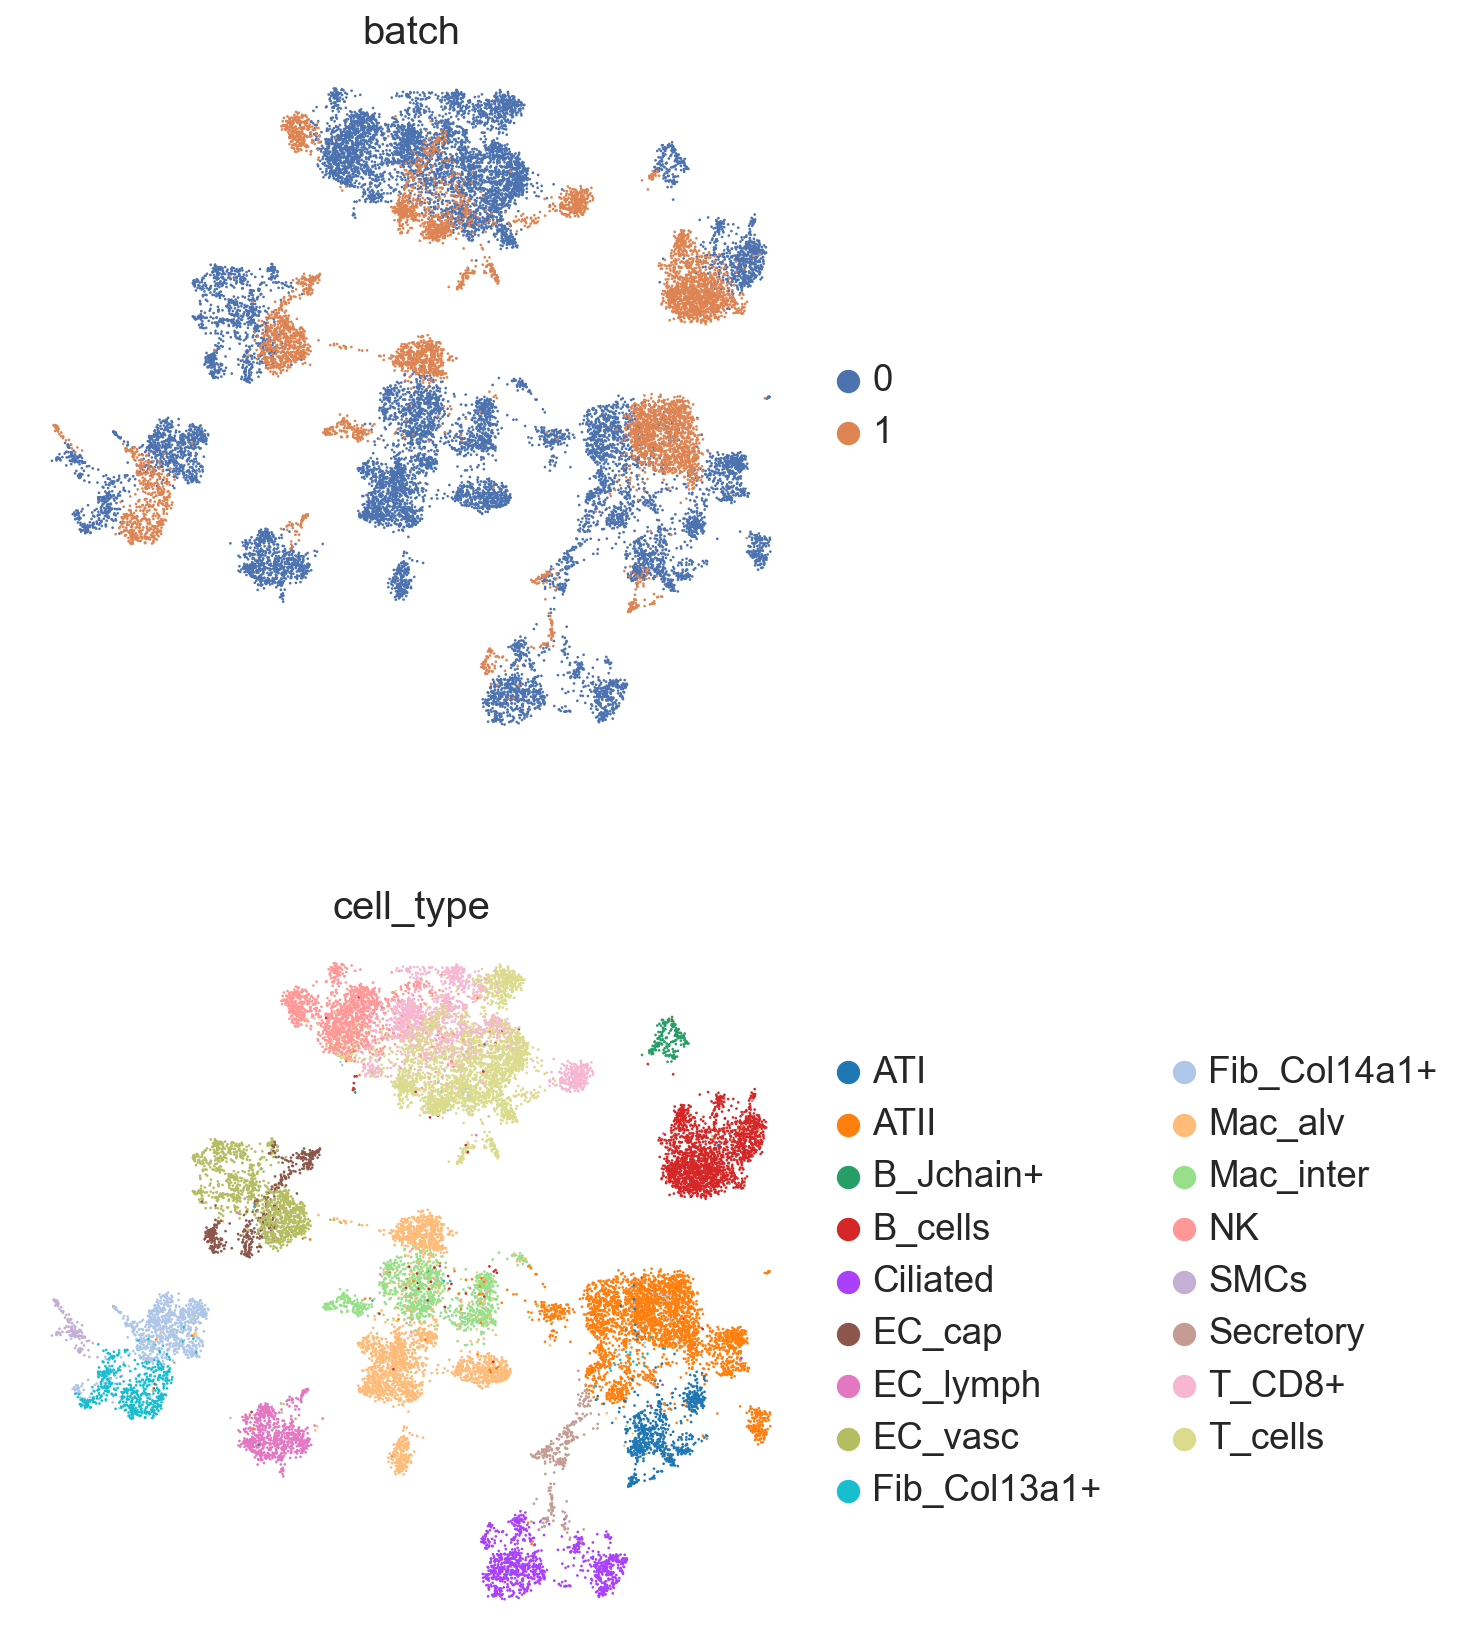

In [11]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [12]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)

In [13]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|█| 20/20 [00:51<00:00,  2.57s/it, v_num=1, train_loss_step=460

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [00:51<00:00,  2.56s/it, v_num=1, train_loss_step=460


In [14]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [15]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict[SCANVI_LATENT_KEY] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [16]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

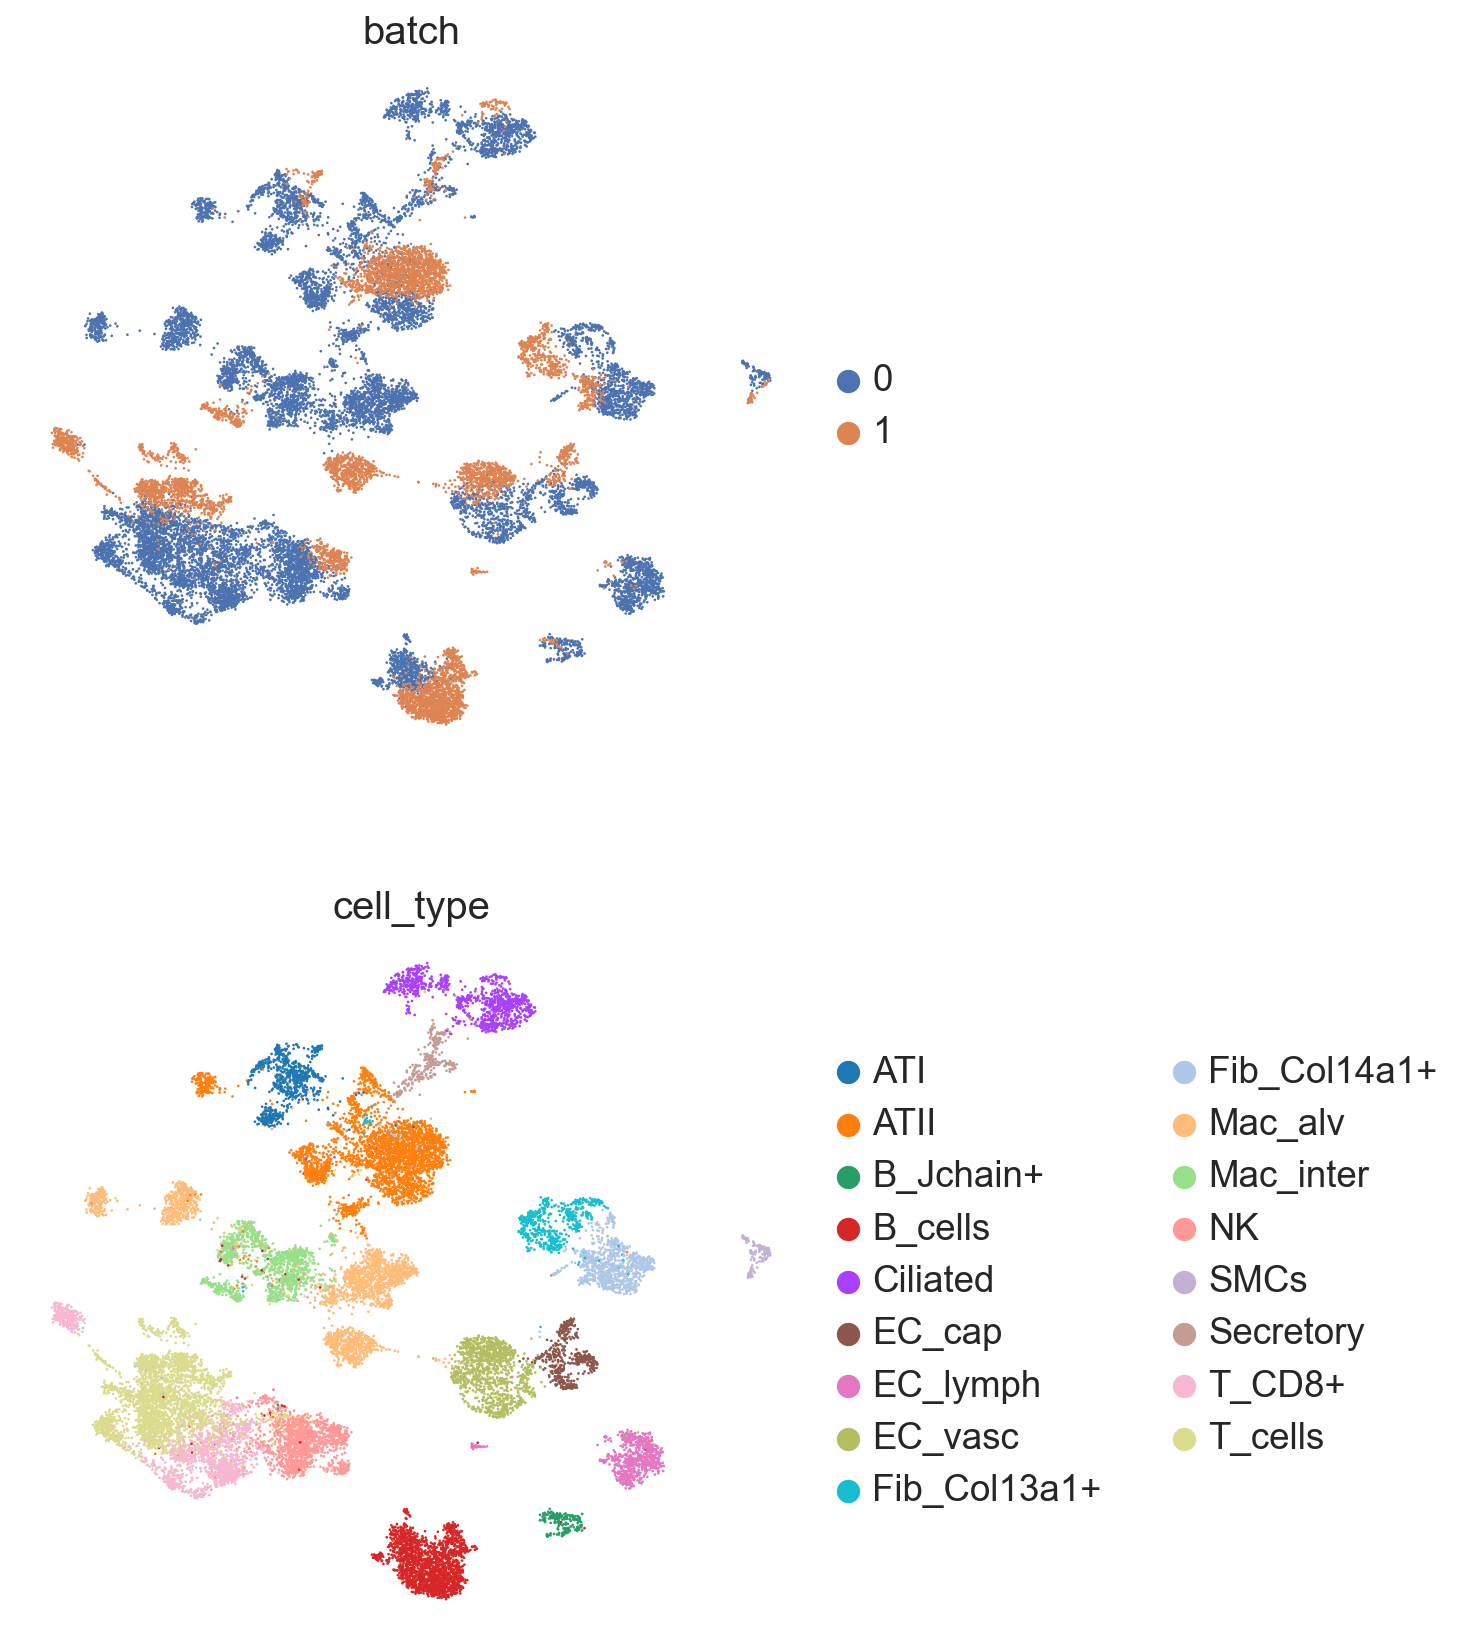

In [17]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [18]:
train = adata.copy()

### Preprocessing Data

In [19]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="cell_type")

## Creating and Training the model¶

In [20]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 26/100:  26%|▎| 26/100 [02:33<07:17,  5.91s/it, v_num=1, train_loss_step=7
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 764.688. Signaling Trainer to stop.


## Batch-Removal

In [21]:
corrected_adata = model.batch_removal()
corrected_adata

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scgen/_scgen.py:268: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_shared_ann = AnnData.concatenate(


AnnData object with n_obs × n_vars = 20760 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sampleid', 'cellname', 'cell_type', 'species', 'batch', 'BATCH', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [22]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [23]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


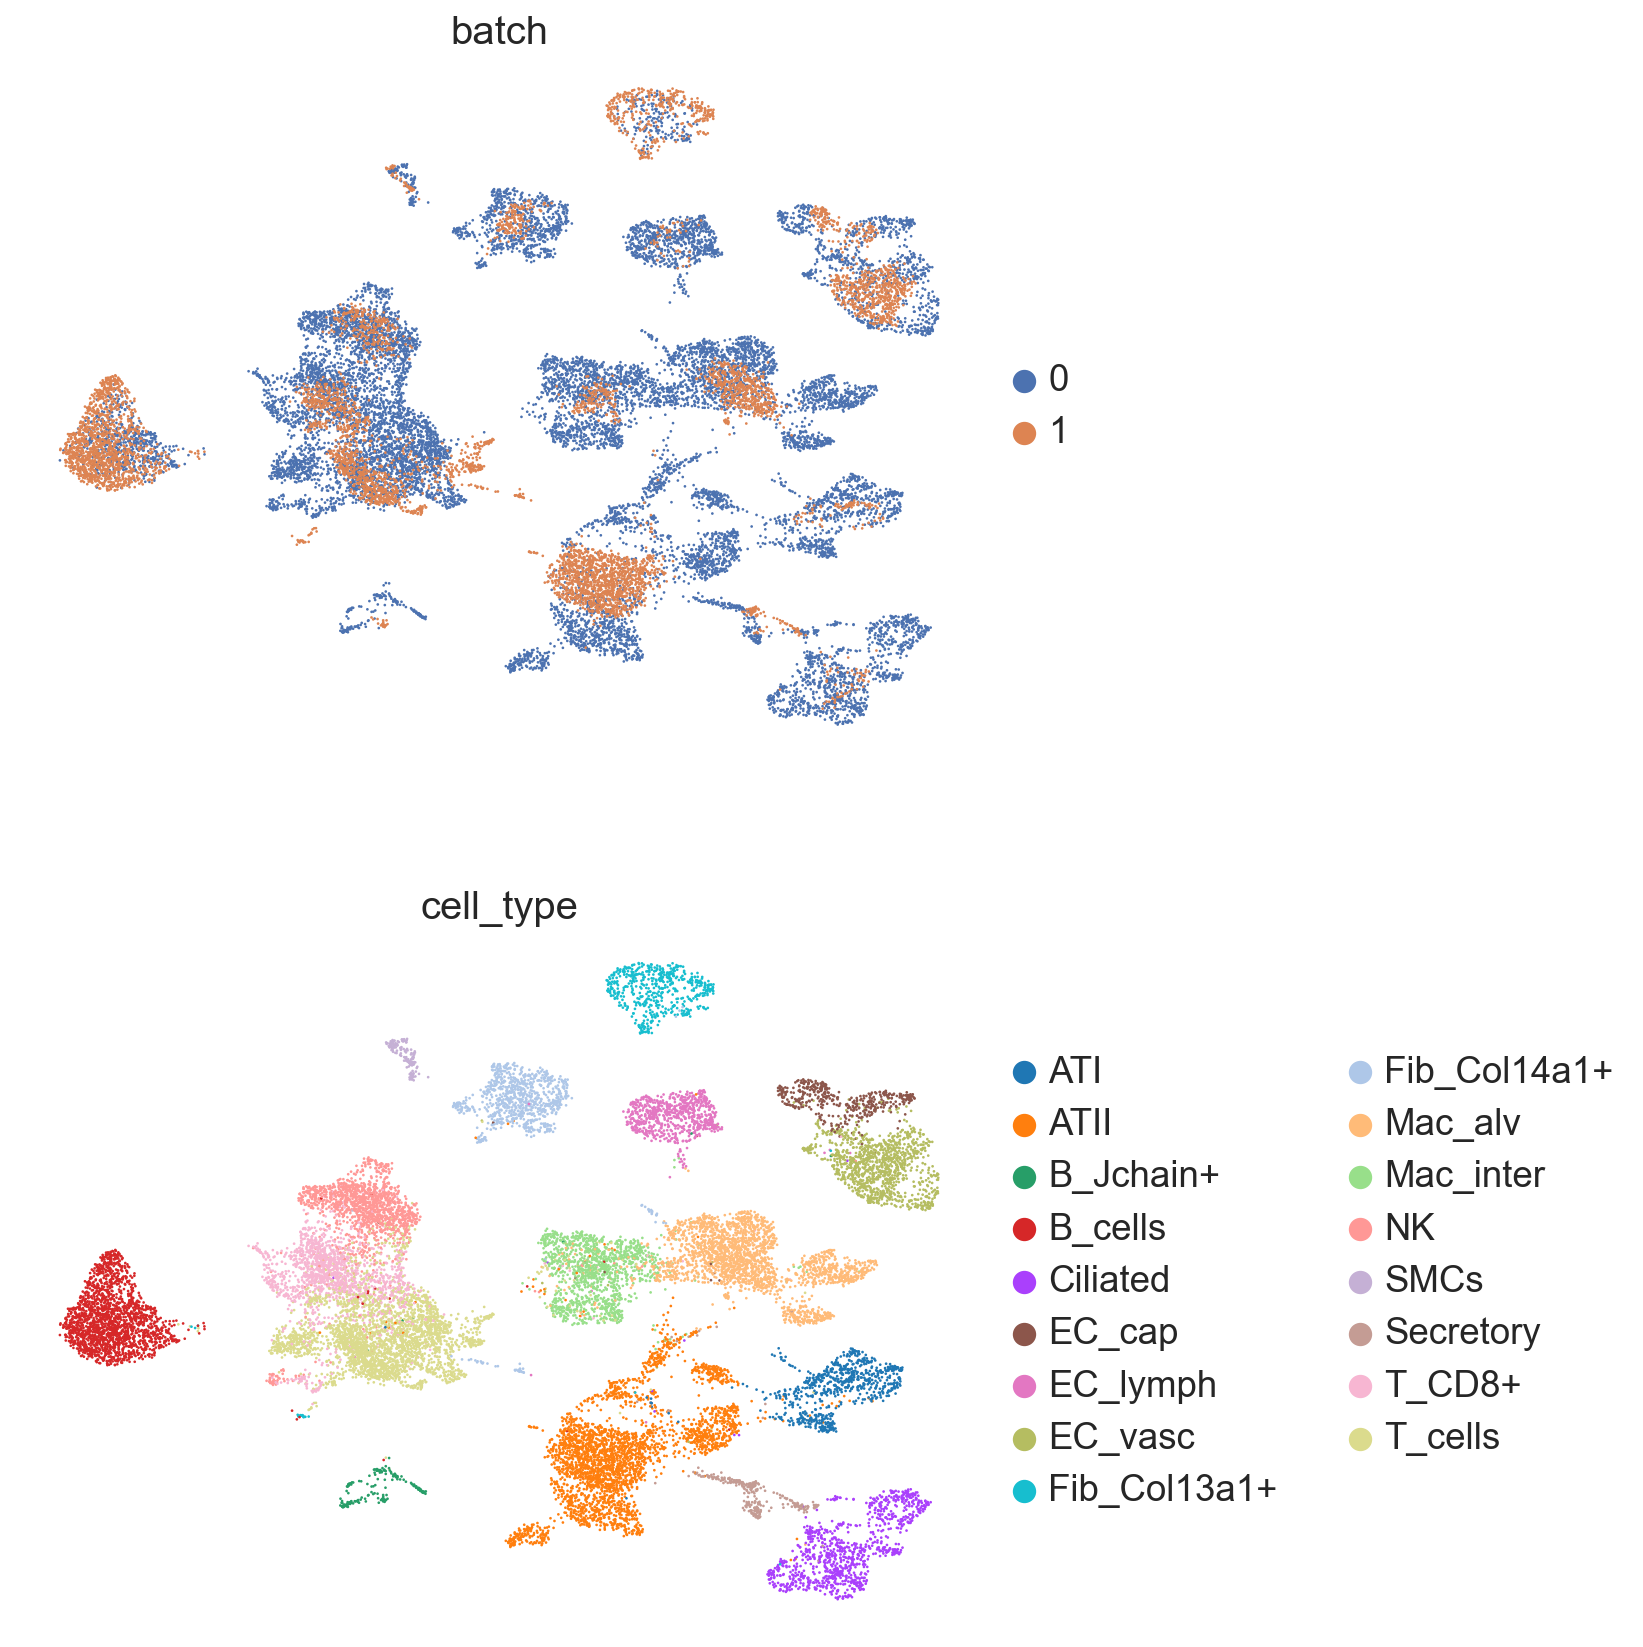

In [26]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type'], wspace=0.4, frameon=False, ncols=1)

# scDREAMER

In [27]:
import scDREAMER

Instructions for updating:
non-resource variables are not supported in the long term


In [28]:
import tensorflow as tf
from scDREAMER import scDREAMER_SUP

# Define the single dataset and relevant parameters
name = "Lung_two_species"
dataset_path = "../Lung_two_species_raw.h5ad"

# Define batch and cell type keys
batch_key = 'batch'
cell_type_key = 'celltype'

# Learning rate configuration
lr = {"lr_ae": 0.0002, "lr_dis": 0.0007}

# TensorFlow session configuration
tf.compat.v1.disable_eager_execution()  # Disable eager execution to mimic TensorFlow 1.x behavior
run_config = tf.compat.v1.ConfigProto()
run_config.gpu_options.per_process_gpu_memory_fraction = 0.333
run_config.gpu_options.allow_growth = True

# Run scDREAMER
with tf.compat.v1.Session(config=run_config) as sess:
    dreamer = scDREAMER_SUP(
        sess,
        epoch=300,
        dataset_name=dataset_path,
        batch=batch_key,
        cell_type=cell_type_key,
        plot_cell_type=cell_type_key,
        name=name,
        lr_ae=lr['lr_ae'],
        lr_dis=lr['lr_dis']
    )

    dreamer.train_cluster()

Loading dataset
Preprocessing...
here [11 11 11 ...  4  4  4]
Shape self.data_train: (20760, 2000)
Shape self.data_test: (20760, 2000)
encoder input shape  Tensor("concat:0", shape=(?, 2002), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
decoder input shape  Tensor("concat_2:0", shape=(?, 12), dtype=float32)
KL gaussian z Tensor("mul_12:0", shape=(?,), dtype=float32)
KL gaussian l Tensor("mul_11:0", shape=(?,), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

scDREAMER-Sup on DataSet ../Lung_two_species_raw.h5ad ... 
Epoch : [0] ,  a_loss = 100.6751
Epoch : [10] ,  a_loss = 53.7312
Epoch : [20] ,  a_loss = 47.9852
Epoch : [30] ,  a_loss = 45.4477
Epoch : [31] ,  a_loss = nan
Epoch : [31] ,  a_loss = 

ValueError: Input contains NaN.

In [ ]:
import pandas as pd
pca_embeddings = pd.read_csv('./lung_atlas_scdreamer_embeddings_full_labels.csv', index_col=0)
adata.obsm['X_scDREAMER'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_scDREAMER")
sc.tl.umap(adata, min_dist=0.5)

In [ ]:
# Collect embeddings
embeddings_dict["X_scDREAMER"] = pca_embeddings.values

In [ ]:
sc.pl.umap(adata, color=["batch", "celltype"], frameon=False, ncols=1)

# STACAS

Semi-supervised integration results

In [29]:
pca_embeddings = pd.read_csv('../R_lung_two_species/embeddings/lung_two_species_stacas_embeddings_full_labels.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [30]:
# Collect embeddings
embeddings_dict["X_stacas"] = pca_embeddings.values

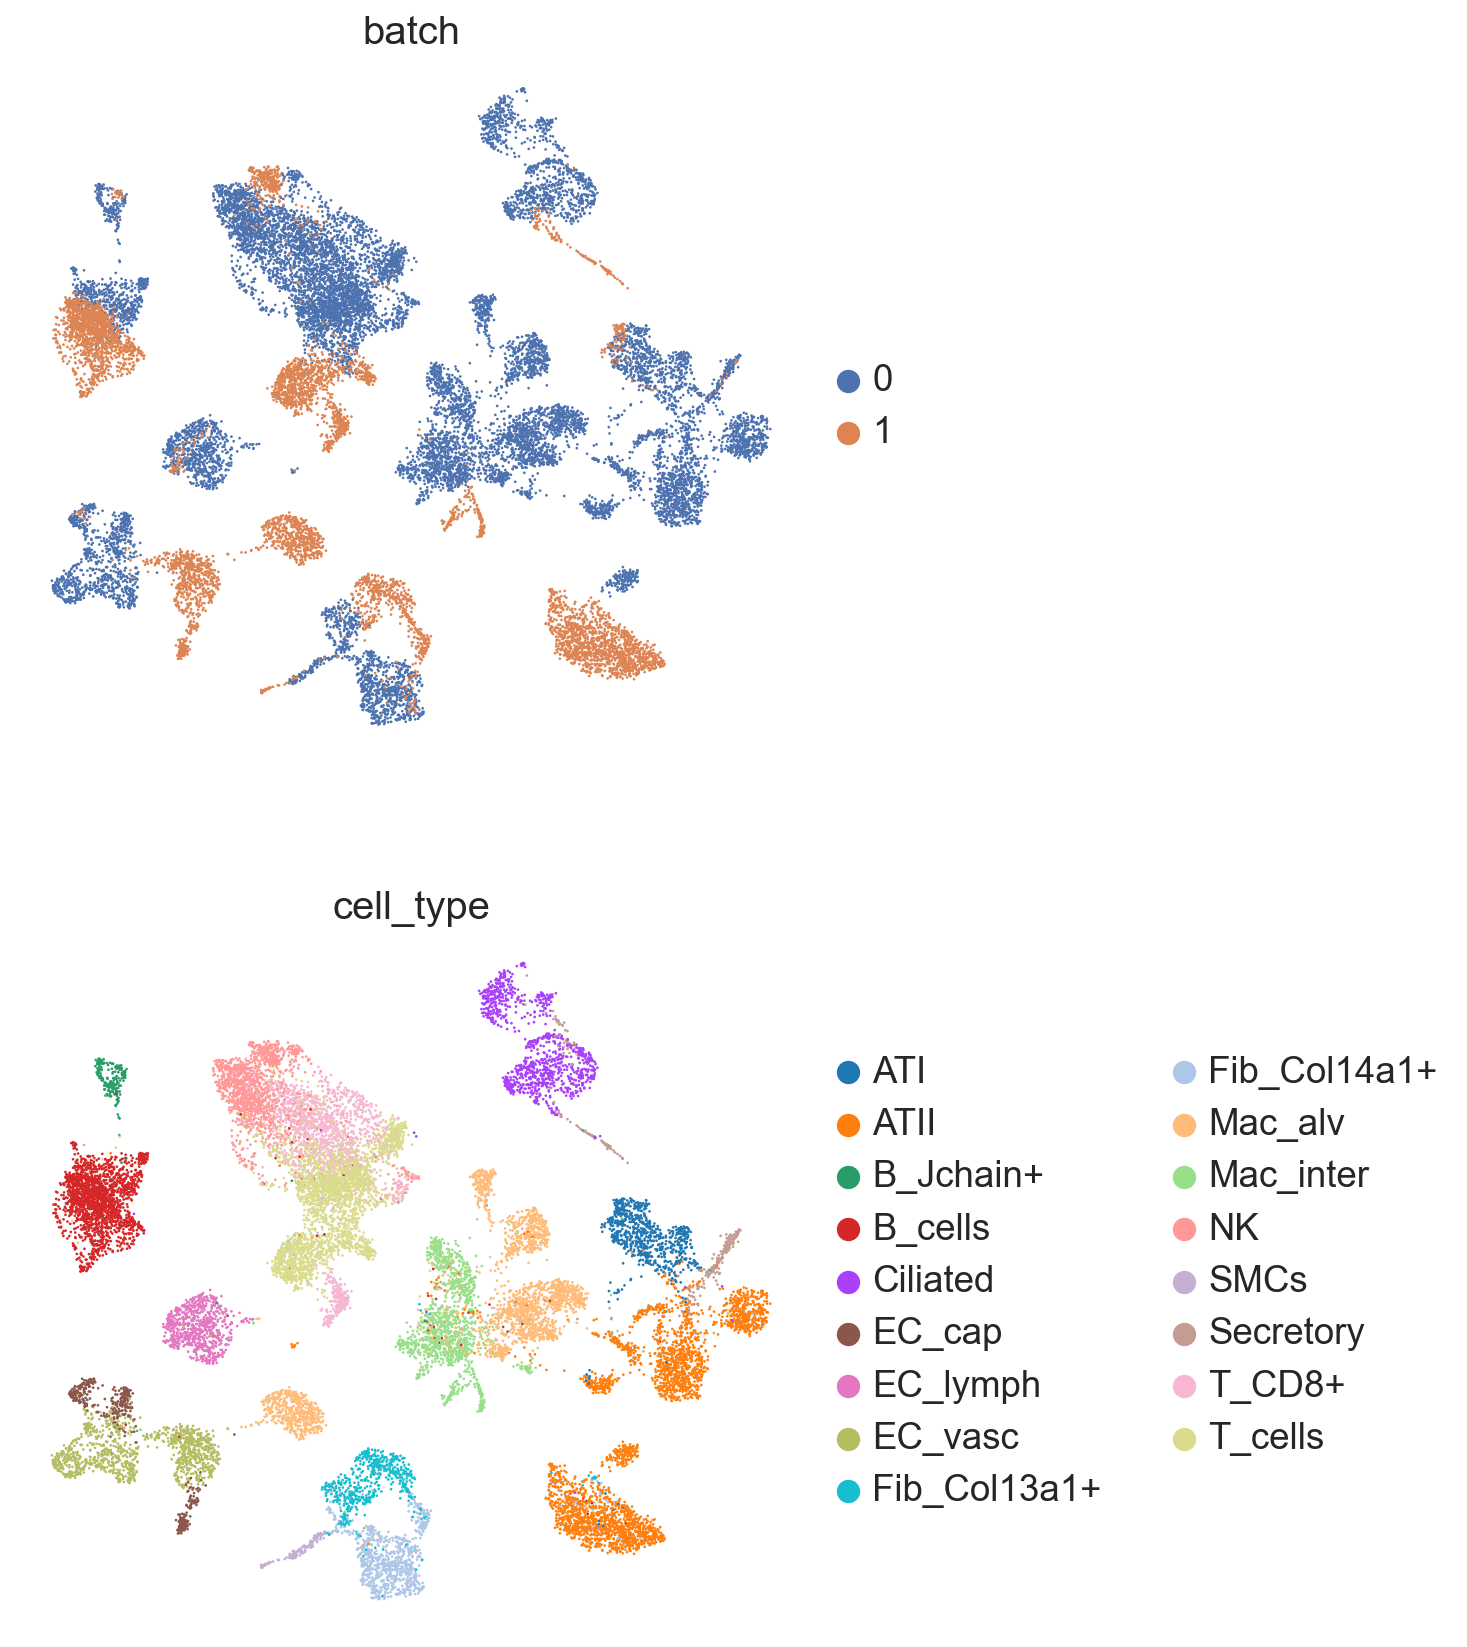

In [31]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [32]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/full_annotated_supervised_lung_two_species.csv")


# Metric Evaluation

## read the embeddings

In [33]:
# Step 1: Read the CSV file into a DataFrame
import pandas as pd

combined_embeddings = pd.read_csv("../embeddings/full_annotated_supervised_lung_two_species.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [34]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

resolution: 0.1, nmi: 0.8312940117807928
resolution: 0.2, nmi: 0.8529897747674059
resolution: 0.3, nmi: 0.8370769397109059
resolution: 0.4, nmi: 0.8428591267336256
resolution: 0.5, nmi: 0.8415824778086158
resolution: 0.6, nmi: 0.8424428888793905
resolution: 0.7, nmi: 0.8311780365329258
resolution: 0.8, nmi: 0.8356327908455087
resolution: 0.9, nmi: 0.8174122061055769
resolution: 1.0, nmi: 0.8202292500730131
resolution: 1.1, nmi: 0.8122474434313643
resolution: 1.2, nmi: 0.8024323672383991
resolution: 1.3, nmi: 0.7916979084971737
resolution: 1.4, nmi: 0.7923272630380085
resolution: 1.5, nmi: 0.7936314660353618
resolution: 1.6, nmi: 0.7792026510573163
resolution: 1.7, nmi: 0.7784063908967661
resolution: 1.8, nmi: 0.7746833968789174
resolution: 1.9, nmi: 0.7715701098818547
resolution: 2.0, nmi: 0.7663545481521173
optimised clustering against cell_type
optimal cluster resolution: 0.2
optimal score: 0.8529897747674059
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors o

In [38]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

resolution: 0.1, nmi: 0.8325042167278911
resolution: 0.2, nmi: 0.8401594111893691
resolution: 0.3, nmi: 0.8556055059302149
resolution: 0.4, nmi: 0.8567688778995844
resolution: 0.5, nmi: 0.8499989119662221
resolution: 0.6, nmi: 0.8620622714434165
resolution: 0.7, nmi: 0.8546815581513254
resolution: 0.8, nmi: 0.8509816024994443
resolution: 0.9, nmi: 0.8300670487976238
resolution: 1.0, nmi: 0.8268727191899756
resolution: 1.1, nmi: 0.8259877454067457
resolution: 1.2, nmi: 0.8253570367323589
resolution: 1.3, nmi: 0.8239416733365574
resolution: 1.4, nmi: 0.8151162139621349
resolution: 1.5, nmi: 0.8098968455284243
resolution: 1.6, nmi: 0.8004886967871431
resolution: 1.7, nmi: 0.8019943150469617
resolution: 1.8, nmi: 0.7975034643947256
resolution: 1.9, nmi: 0.7921471901210982
resolution: 2.0, nmi: 0.7878453018609242
optimised clustering against cell_type
optimal cluster resolution: 0.6
optimal score: 0.8620622714434165
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors o

In [39]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

resolution: 0.1, nmi: 0.7826026764144165
resolution: 0.2, nmi: 0.7763735645777218
resolution: 0.3, nmi: 0.7729037138284645
resolution: 0.4, nmi: 0.7706589680933854
resolution: 0.5, nmi: 0.7687664359564961
resolution: 0.6, nmi: 0.7673214520282285
resolution: 0.7, nmi: 0.7718612176484221
resolution: 0.8, nmi: 0.7591262291474471
resolution: 0.9, nmi: 0.7605039127101663
resolution: 1.0, nmi: 0.7658609497374801
resolution: 1.1, nmi: 0.7638426198639288
resolution: 1.2, nmi: 0.7652676925410214
resolution: 1.3, nmi: 0.762201185566278
resolution: 1.4, nmi: 0.7511231714790386
resolution: 1.5, nmi: 0.7534982384483213
resolution: 1.6, nmi: 0.7497715343100059
resolution: 1.7, nmi: 0.7457131044186768
resolution: 1.8, nmi: 0.7425039678065287
resolution: 1.9, nmi: 0.738176219327817
resolution: 2.0, nmi: 0.741155007952799
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.7826026764144165
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on r

In [43]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df

merged_df.to_csv("../metrics/lung_two_species_metrics_supervised_full.csv", index=True)

In [42]:
merged_df

,scANVI,scGEN,STACAS
NMI_cluster/label,0.852003,0.863035,0.789562
ARI_cluster/label,0.742785,0.762498,0.588132
ASW_label,0.632002,0.608759,0.620782
ASW_label/batch,0.844839,0.875717,0.776541
PCR_batch,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN
isolated_label_F1,0.929894,0.936764,0.829290
isolated_label_silhouette,0.639669,0.609685,0.625133
graph_conn,0.992817,0.990761,0.984244
kBET,NaN,NaN,NaN
